# Telegram-Leecher

1. UPLOAD YOUR THUMBNAIL (OPTIONAL) ( thmb.jpg < 200KB )

2. UPLOAD YOUR token.pickle file ( REQUIRED !! )

### NOTE: File names should be exactly same as mentioned

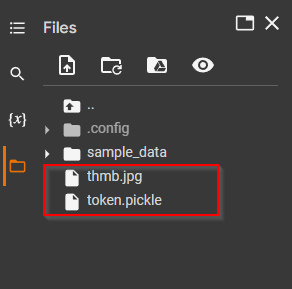

## Download and set up required files by running the cell

In [ ]:
!git clone https://github.com/XronTrix10/Telegram-Leecher &>/dev/null && bash /content/Telegram-Leecher/setup.sh &>/dev/null

print('Files and modules setup Successfull')

## Edit the Variables with your data and run the cell

In [ ]:
api_id    =             # <== YOUR TELEGRAM API ID HERE
api_hash  = ""          # <== YOUR TELEGRAM API HASH HERE ( Place Inside Quotes )
bot_token = ""          # <== YOUR TELEGRAM BOT TOKEN HERE ( Place Inside Quotes )
chat_id   =             # <== YOUR CHAT ID WHERE ALL STATUS AND LOGS WILL BE SHOWN
dump_id   =             # <== CHAT ID WHERE ALL FILES WILL BE UPLOADED ( MUST BE A CHANNEL OR SUPERGROUP )

# NOTE: Make sure to add the Bot to the Dump Channel/Super-Group as Admin

print('BOT Variables Initialized !')

# RUN THIS MAIN CODE TO START LEECHING

### Don't Worry about the red line errors, it will run fine !

In [ ]:
import os
import shutil
import io
import time
import sys
import re
import cv2
import pickle
import uvloop
import zipfile
import datetime
import requests
import posixpath
import subprocess
from urllib.parse import urlparse
from PIL import Image
from natsort import natsorted
from IPython.display import clear_output
from pyrogram import Client
from re import search as re_search
from urllib.parse import parse_qs, urlparse
from os import makedirs, path as ospath
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload
from pyrogram.types import (ReplyKeyboardMarkup, InlineKeyboardMarkup,
                            InlineKeyboardButton)

uvloop.install()


# =================================================================
#    Local OS Functions
# =================================================================


def get_time():
    currentDateAndTime = datetime.datetime.now()
    currentTime = currentDateAndTime.strftime("%H:%M:%S")
    return currentTime

def convert_seconds(seconds):
    seconds = int(seconds)
    days = seconds // (24 * 3600)
    seconds = seconds % (24 * 3600)
    hours = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    if days > 0:
        return f"{days}d {hours}h {minutes}m {seconds}s"
    elif hours > 0:
        return f"{hours}h {minutes}m {seconds}s"
    elif minutes > 0:
        return f"{minutes}m {seconds}s"
    else:
        return f"{seconds}s"



def size_measure(size):

    if size > 1024 * 1024 * 1024 * 1024:
        siz = f"{size/(1024**4):.2f} TB"
    elif size > 1024 * 1024 * 1024:
        siz = f"{size/(1024**3):.2f} GB"
    elif size > 1024 * 1024:
        siz = f"{size/(1024**2):.2f} MB"
    elif size > 1024:
        siz = f"{size/1024:.2f} KB"
    else:
        siz = f"{size} B"
    return siz


def get_file_type(file_path):
    name, extension = os.path.splitext(file_path)

    extensions_dict = {
        ".mp4": "video",
        ".avi": "video",
        ".mkv": "video",
        ".mov": "video",
        ".webm": "video",
        ".m4v": "video",
        ".mp3": "audio",
        ".wav": "audio",
        ".flac": "audio",
        ".aac": "audio",
        ".ogg": "audio",
        ".jpg": "photo",
        ".jpeg": "photo",
        ".png": "photo",
        ".gif": "photo",
    }

    if extension in extensions_dict:
        if extensions_dict[extension] == "video":
            video_extension_fixer(file_path)
        return extensions_dict[extension]
    else:
        return "document"


def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size


def get_file_count(folder_path):
    count = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            count += 1
    return count


def video_extension_fixer(file_path):

    dir_path, filename = os.path.split(file_path)

    if filename.endswith(".mp4") or filename.endswith(".mkv"):
        pass
    # split the file name and the extension
    else:
        # rename the video file with .mp4 extension
        name, ext = os.path.splitext(filename)
        os.rename(
            os.path.join(dir_path, filename), os.path.join(
                dir_path, name + ".mp4")
        )
        print(f"{filename} was changed to {name}.mp4")


async def zip_folder(folder_path):

    output_path = folder_path + ".zip"
    # Calculate total size of folder to track progress
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)

    # Create zip file object
    with zipfile.ZipFile(output_path, "w", zipfile.ZIP_DEFLATED) as zip_file:
        # Walk through each file in the folder
        current_size = 0
        for dirpath, dirnames, filenames in os.walk(folder_path):
            for f in filenames:
                fp = os.path.join(dirpath, f)

                # Add file to zip file object and print progress
                with open(fp, "rb") as file:
                    relative_path = os.path.relpath(fp, folder_path)
                    zip_file.write(fp, arcname=relative_path)
                    current_size += os.path.getsize(fp)
                    percentage = int((current_size / total_size) * 100)
                    print(
                        f"Zipping - {percentage:.2f}%"
                        + f" ({size_measure(current_size)}/{size_measure(total_size)})"
                    )

                    # Delete the file after writing it to the zip object.
                    os.remove(fp)

                    bar_length = 14
                    filled_length = int(percentage / 100 * bar_length)
                    bar = "⬢" * filled_length + "⬡" * \
                        (bar_length - filled_length)
                    message = (
                        f"\n[{bar}] » {percentage:.2f}%"
                        + f"\n✅ DONE: __{size_measure(current_size)}__ OF __{size_measure(total_size)}__"
                    )

                    try:
                        # Edit the message with updated progress information.
                        if is_time_over(current_time):
                            await bot.edit_message_text(
                                chat_id=chat_id,
                                message_id=msg.id,
                                text=down_msg + message,
                            )

                    except Exception as e:
                        # Catch any exceptions that might occur while editing the message.
                        print(f"Error updating progress bar: {str(e)}")

    return output_path


async def extract_zip(zip_filepath):

    if not os.path.exists(temp_unzip_path):
        makedirs(temp_unzip_path)

    with zipfile.ZipFile(zip_filepath) as zf:
        num_files = len(zf.infolist())

        total_size = sum(file.file_size for file in zf.infolist())
        extracted_size = 0
        print(f"Extracting {num_files} files...")
        for i, member in enumerate(zf.infolist(), 1):
            # print(f"Extracting {member.filename} ({member.file_size} bytes)")
            extracted_size += member.file_size
            zf.extract(member, temp_unzip_path)
            percent_complete = (extracted_size / total_size) * \
                100 if total_size else 0

            down_msg = f"<b>📂 EXTRACTING:</b>\n\n<code>{d_name}</code>\n"

            bar_length = 14
            filled_length = int(percent_complete / 100 * bar_length)
            bar = "⬢" * filled_length + "⬡" * (bar_length - filled_length)
            message = (
                f"\n[{bar}] » {percent_complete:.2f}%"
                + f"\n✅ DONE: __{size_measure(extracted_size)}__ OF "
                + f"__{size_measure(os.stat(zip_filepath).st_size)}__"
            )

            print(message)

            try:
                # Edit the message with updated progress information.
                if is_time_over(current_time):
                    await bot.edit_message_text(
                        chat_id=chat_id,
                        message_id=msg.id,
                        text=down_msg + message,
                    )

            except Exception as e:
                # Catch any exceptions that might occur while editing the message.
                print(f"Error updating progress bar: {str(e)}")


async def size_checker(file_path):

    max_size = 2097152000  # 2 GB
    file_size = os.stat(file_path).st_size

    if file_size > max_size:

        print(f"File size is {size_measure(file_size)} SPLITTING.......")

        if not ospath.exists(temp_lpath):
            makedirs(temp_lpath)

        await split_zipFile(file_path, max_size)

        return True
    else:

        print(
            f"File size is {size_measure(file_size)} MB. NOT SPLITTING.......")
        return False


async def split_zipFile(file_path, max_size):
    dir_path, filename = os.path.split(file_path)
    new_path = f"{temp_lpath}/{filename}"
    down_msg = (
        f"<b>✂️ SPLITTING !</b>\n\n<code>{d_name}</code>\n"
        + f"\nSIZE: {size_measure(os.stat(file_path).st_size)}\n"
    )
    # Get the total size of the file
    total_size = os.path.getsize(file_path)

    with open(file_path, "rb") as f:
        chunk = f.read(max_size)
        i = 1
        bytes_written = 0

        while chunk:
            # Generate filename for this chunk
            ext = str(i).zfill(3)
            output_filename = "{}.{}".format(new_path, ext)

            # Write chunk to file
            with open(output_filename, "wb") as out:
                out.write(chunk)

            bytes_written += len(chunk)
            progress_percent = bytes_written / total_size * 100

            bar_length = 14
            filled_length = int(progress_percent / 100 * bar_length)
            bar = "⬢" * filled_length + "⬡" * (bar_length - filled_length)
            message = (
                f"\n[{bar}] » {progress_percent:.2f}%"
                + f"\n✅ DONE: __{size_measure(bytes_written)}__ OF __{size_measure(total_size)}__"
            )
            print(message)
            try:
                await bot.edit_message_text(
                    chat_id=chat_id,
                    message_id=msg.id,
                    text=down_msg + message,
                )
            except Exception as e:
                # Catch any exceptions that might occur while editing the message.
                print(f"Error updating progress bar: {str(e)}")

            # Get next chunk
            chunk = f.read(max_size)
            # Increment chunk counter
            i += 1


def is_time_over(current_time):
    ten_sec_passed = time.time() - current_time[0] >= 3
    if ten_sec_passed:
        current_time[0] = time.time()
    return ten_sec_passed


# =================================================================
#    Direct Link Handler Functions
# =================================================================


async def on_output(line: str, content_length):

    down_msg = ""

    match = re.search(r"(\d+[KMGT]?)K\s+.*\s+(\d+)%", line)
    if match:
        kilobytes_progress, percentage = match.groups()

        # Convert progress to Bytes
        progress_in_bytes = int(kilobytes_progress) * 1024
        down_done = size_measure(progress_in_bytes)

        bar_length = 14
        filled_length = int(int(percentage) / 100 * bar_length)
        bar = "⬢" * filled_length + "⬡" * (bar_length - filled_length)

        # Calculate download speed
        elapsed_time_seconds = (datetime.datetime.now() - start_time).seconds
        try:
            current_speed = progress_in_bytes / elapsed_time_seconds
            speed_string = f"{size_measure(current_speed)}/s"
            eta = (content_length - int(progress_in_bytes)) / current_speed
            eta = convert_seconds(eta)
            message = f"\n[{bar}] » {percentage:.2f}%\n⚡️ __{speed_string}__  ⏳ ETA: __{eta}__\n✅ DONE: __{down_done}__ OF __{size_measure(int(content_length))}__"

        except Exception as e1:
            print(f"Error On Output: {e1}")
            message = f"\nRetrying updating Progress....."

        down_msg = f"<b>📥 DOWNLOADING:</b>\n\n<code>{d_name}</code>\n"

    else:
        message = line.strip()

    print(message)

    try:
        # Edit the message with updated progress information.
        if is_time_over(current_time):
            await bot.edit_message_text(
                chat_id=chat_id, message_id=msg.id, text=down_msg + message,                                
                reply_markup=InlineKeyboardMarkup(
                                        [
                                            [  # First row
                                                InlineKeyboardButton(  # Opens a web URL
                                                    "Source URL 🔗",
                                                    url=link
                                                ),
                                                InlineKeyboardButton(  # Opens a web URL
                                                    "BOT REPO 🐈‍⬛",
                                                    url="https://github.com/XronTrix10/Telegram-Leecher"
                                                )
                                            ]
                                        ]
            ))

    except Exception as e:
        # Catch any exceptions that might occur while editing the message.
        print(f"Error updating progress bar: {str(e)}")


async def wgetDownload(link):

    global start_time, d_name, d_fol_path
    filename = ""

    try:
        # Get header info using requests
        response = requests.head(link)
        if response.status_code == 200:
            content_length = int(response.headers.get("Content-Length", 0))
            print(f"Total download size: {size_measure(content_length)}")
            content_disposition = response.headers.get("Content-Disposition")
            if content_disposition:
                filename_match = re.search(
                    r'filename="(.+)"', content_disposition)
                if filename_match:
                    filename = filename_match.group(1)
                else:
                    parsed_url = urlparse(link)
                    filename = posixpath.basename(parsed_url.path)
            d_name = filename
            print(f"Filename: {filename}")
        else:
            print("Error: Could not get header information", file=sys.stderr)
            sys.exit(1)

        d_fol_path = f"{d_path}/{d_name}"
        if not ospath.exists(d_fol_path):
            makedirs(d_fol_path)

        downlod_path = f"{d_fol_path}/{d_name}"

        # Start actual download
        wget_command = f"wget -q --show-progress {link} -O {downlod_path}"
        process = subprocess.Popen(
            wget_command,
            shell=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
        )

        current_time[0] = time.time()
        start_time = datetime.datetime.now()
        for line in process.stdout:
            await on_output(line, content_length)

        exit_code = process.wait()
        if exit_code != 0:
            print(f"Error: wget exited with code {exit_code}", file=sys.stderr)
            sys.exit(exit_code)

    except requests.RequestException as e:
        print(f"Error: {str(e)}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"Unexpected error: {str(e)}", file=sys.stderr)
        sys.exit(1)


# =================================================================
#    G Drive Functions
# =================================================================


def build_service():

    # create credentials object from token.pickle file
    creds = None
    if os.path.exists("/content/token.pickle"):
        with open("/content/token.pickle", "rb") as token:
            creds = pickle.load(token)
    else:
        exit(1)

    # create drive API client
    service = build("drive", "v3", credentials=creds)

    return service


async def g_DownLoad(link):

    global d_fol_path, start_time, d_name

    file_id = getIDFromURL(link)

    meta = getFileMetadata(file_id)

    d_name = meta["name"]

    d_fol_path = f"{d_path}/{d_name}"

    if meta.get("mimeType") == "application/vnd.google-apps.folder":

        folder_info[0] = get_Gfolder_size(file_id)
        print(f"\nTotal Download size is: {size_measure(folder_info[0])}")
        current_time[0] = time.time()
        start_time = datetime.datetime.now()
        await gDownloadFolder(file_id, d_path)
        clear_output()
        print("*" * 40 + "\n Folder Download Complete\n" + "*" * 40)

    else:

        file_metadata = getFileMetadata(file_id)
        folder_info[0] = int(
            file_metadata["size"]
        )  # Get the file size from the metadata:
        print(f"\nTotal Download size is: {size_measure(folder_info[0])}")
        if not ospath.exists(d_fol_path):
            makedirs(d_fol_path)
        current_time[0] = time.time()
        start_time = datetime.datetime.now()
        await gDownloadFile(file_id, d_fol_path)
        clear_output()
        print("*" * 40 + "\n File Download Complete\n" + "*" * 40)


def getIDFromURL(link: str):
    if "folders" in link or "file" in link:
        regex = r"https:\/\/drive\.google\.com\/(?:drive(.*?)\/folders\/|file(.*?)?\/d\/)([-\w]+)"
        res = re_search(regex, link)
        if res is None:
            raise IndexError("G-Drive ID not found.")
        return res.group(3)
    parsed = urlparse(link)
    return parse_qs(parsed.query)["id"][0]


def getFilesByFolderID(folder_id):
    page_token = None
    files = []
    while True:
        response = (
            service.files()
            .list(
                supportsAllDrives=True,
                includeItemsFromAllDrives=True,
                q=f"'{folder_id}' in parents and trashed = false",
                spaces="drive",
                pageSize=200,
                fields="nextPageToken, files(id, name, mimeType, size, shortcutDetails)",
                orderBy="folder, name",
                pageToken=page_token,
            )
            .execute()
        )
        files.extend(response.get("files", []))
        page_token = response.get("nextPageToken")
        if page_token is None:
            break
    return files


def getFileMetadata(file_id):
    return (
        service.files()
        .get(fileId=file_id, supportsAllDrives=True, fields="name, id, mimeType, size")
        .execute()
    )


def get_Gfolder_size(folder_id):
    try:
        query = "trashed = false and '{0}' in parents".format(folder_id)
        results = (
            service.files()
            .list(
                supportsAllDrives=True,
                includeItemsFromAllDrives=True,
                q=query,
                fields="files(id, mimeType, size)",
            )
            .execute()
        )

        total_size = 0
        items = results.get("files", [])

        folders_without_size = (
            item["id"]
            for item in items
            if item.get("size") is None
            and item["mimeType"] == "application/vnd.google-apps.folder"
        )

        for item in items:
            # If the item has a size attribute
            if "size" in item:
                total_size += int(item["size"])

        # Recursively call the function for folders whose size is not found
        for folder_id in folders_without_size:
            total_size += get_Gfolder_size(folder_id)

        return total_size

    except HttpError as error:
        print(f"Error while checking size: {error}")
        return -1


async def downloadProgress(file_size):

    global start_time

    down_done = sum(down_bytes) + file_size

    speed_string = ""

    if down_done > 0:
        elapsed_time_seconds = (datetime.datetime.now() - start_time).seconds
        down_speed = down_done / elapsed_time_seconds
        speed_string = f"{size_measure(down_speed)}/s"

    eta = (folder_info[0] - down_done) / down_speed
    eta = convert_seconds(eta)

    down_msg = f"<b>📥 DOWNLOADING: {down_count[0]} Files</b>\n\n<code>{d_name}</code>\n"

    percentage = down_done / folder_info[0] * 100
    bar_length = 14
    filled_length = int(percentage / 100 * bar_length)
    bar = "⬢" * filled_length + "⬡" * (bar_length - filled_length)
    message = f"\n[{bar}] » {percentage:.2f}%\n⚡️ __{speed_string}__  ⏳ ETA: __{eta}__\n✅ DONE: __{size_measure(down_done)}__ OF __{size_measure(folder_info[0])}__"
    try:
        print(message)
        # Edit the message with updated progress information.
        if is_time_over(current_time):
            await bot.edit_message_text(
                chat_id=chat_id, message_id=msg.id, text=down_msg + message,
                                reply_markup=InlineKeyboardMarkup(
                                        [
                                            [  # First row
                                                InlineKeyboardButton(  # Opens a web URL
                                                    "Source URL 🔗",
                                                    url=link
                                                ),
                                                InlineKeyboardButton(  # Opens a web URL
                                                    "BOT REPO 🐈‍⬛",
                                                    url="https://github.com/XronTrix10/Telegram-Leecher"
                                                )
                                            ]
                                        ]
            ))

    except Exception as e:
        # Catch any exceptions that might occur while editing the message.
        print(f"Error updating progress bar: {str(e)}")


async def gDownloadFile(file_id, path):
    # Check if the specified file or folder exists and is downloadable.
    try:
        file = getFileMetadata(file_id)
    except HttpError as error:
        print("An error occurred: {0}".format(error))
        file = None
    if file is None:
        print(
            "Sorry, the specified file or folder does not exist or is not accessible."
        )
    else:
        if file["mimeType"].startswith("application/vnd.google-apps"):
            print(
                "Sorry, the specified ID is for a Google Docs, Sheets, Slides, or Forms document. You can only download these types of files in specific formats."
            )
        else:

            try:
                file_name = file.get("name", f"untitleddrivefile_{file_id}")
                file_name = os.path.join(path, file_name)
                # Create a BytesIO stream to hold the downloaded file data.
                file_contents = io.BytesIO()

                # Download the file or folder contents to the BytesIO stream.
                request = service.files().get_media(
                    fileId=file_id, supportsAllDrives=True
                )
                file_downloader = MediaIoBaseDownload(
                    file_contents, request, chunksize=50 * 1024 * 1024
                )
                done = False
                while done is False:
                    status, done = file_downloader.next_chunk()
                    print(
                        f"Download progress: {int(status.progress() * 100)}%")
                    # Get current value from file_contents.
                    file_contents.seek(0)
                    with open(file_name, "ab") as f:
                        f.write(file_contents.getvalue())
                    # Reset the buffer for the next chunk.
                    file_contents.seek(0)
                    file_contents.truncate()
                    # The saved bytes till now
                    file_d_size = int(status.progress() * int(file["size"]))
                    print(f"Downloaded size: {size_measure(file_d_size)}")
                    await downloadProgress(file_d_size)

                print(f"DOWNLOADED  =>   {os.path.basename(file_name)}")
                down_bytes.append(int(file["size"]))
                down_count[0] += 1

            except Exception as e:
                print("Error downloading: {0}".format(e))


async def gDownloadFolder(folder_id, path):

    folder_meta = getFileMetadata(folder_id)
    folder_name = folder_meta["name"]
    if not ospath.exists(f"{path}/{folder_name}"):
        makedirs(f"{path}/{folder_name}")
    path += f"/{folder_name}"
    result = getFilesByFolderID(folder_id)
    if len(result) == 0:
        return
    result = natsorted(result, key=lambda k: k["name"])
    for item in result:
        file_id = item["id"]
        shortcut_details = item.get("shortcutDetails")
        if shortcut_details is not None:
            file_id = shortcut_details["targetId"]
            mime_type = shortcut_details["targetMimeType"]
        else:
            mime_type = item.get("mimeType")
        if mime_type == "application/vnd.google-apps.folder":
            await gDownloadFolder(file_id, path)
        else:
            await gDownloadFile(file_id, path)


# =================================================================
#    Telegram Upload Functions
# =================================================================


async def progress_bar(current, total):

    global start_time

    speed_string = ""
    upload_speed = 0

    if current > 0:
        elapsed_time_seconds = (datetime.datetime.now() - start_time).seconds
        upload_speed = current / elapsed_time_seconds
        speed_string = f"{size_measure(upload_speed)}/s"

    eta = (total_down_size - current - sum(up_bytes)) / upload_speed
    eta = convert_seconds(eta)

    percentage = (current + sum(up_bytes)) / total_down_size * 100
    bar_length = 14
    filled_length = int(percentage / 100 * bar_length)
    bar = "⬢" * filled_length + "⬡" * (bar_length - filled_length)
    message = (
        f"\n[{bar}] » {percentage:.2f}%\n⚡️ __{speed_string}__"
        + f" ⏳ ETA: __{eta}__\n✅ DONE: __{size_measure(current + sum(up_bytes))}__"
        + f" OF __{size_measure(total_down_size)}__"
    )
    try:
        print(message)
        # Edit the message with updated progress information.
        if is_time_over(current_time):
            await bot.edit_message_text(
                chat_id=chat_id, message_id=msg.id, text=text_msg + message,
                reply_markup=InlineKeyboardMarkup(
                                        [
                                            [  # First row
                                                InlineKeyboardButton(  # Opens a web URL
                                                    "Source URL 🔗",
                                                    url=link
                                                ),
                                                InlineKeyboardButton(  # Opens a web URL
                                                    "BOT REPO 🐈‍⬛",
                                                    url="https://github.com/XronTrix10/Telegram-Leecher"
                                                )
                                            ]
                                        ]
            ))

    except Exception as e:
        # Catch any exceptions that might occur while editing the message.
        print(f"Error updating progress bar: {str(e)}")


async def upload_file(file_path, type, file_name):

    global sent
    # Upload the file
    try:

        caption = f"<code>{file_name}</code>"

        if type == "video":

            with Image.open(thumb_path) as img:
                width, height = img.size

            data = cv2.VideoCapture(file_path)
            frames = data.get(cv2.CAP_PROP_FRAME_COUNT)
            fps = data.get(cv2.CAP_PROP_FPS)
            seconds=0
            if fps != 0:
                seconds = round(frames / fps)

            sent = await sent.reply_video(
                video=file_path,
                supports_streaming=True,
                width=width,
                height=height,
                caption=caption,
                thumb=thumb_path,
                duration=seconds,
                progress=progress_bar,
                reply_to_message_id=sent.id,
            )

        elif type == "audio":

            sent = await sent.reply_audio(
                audio=file_path,
                supports_streaming=True,
                caption=caption,
                thumb=thumb_path,
                progress=progress_bar,
                reply_to_message_id=sent.id,
            )

        elif type == "document":

            sent = await sent.reply_document(
                document=file_path,
                caption=caption,
                thumb=thumb_path,
                progress=progress_bar,
                reply_to_message_id=sent.id,
            )

        elif type == "photo":

            sent = await sent.reply_photo(
                photo=file_path,
                caption=caption,
                progress=progress_bar,
                reply_to_message_id=sent.id,
            )

        clear_output()

        sent_file.append(sent)
        sent_fileName.append(file_name)
        print(f"\n{file_name} Sent !")

    except Exception as e:
        print(e)


async def Leecher(file_path):

    global text_msg, start_time, msg, sent

    file_type = get_file_type(file_path)
    file_name = os.path.basename(file_path)

    leech = await size_checker(file_path)

    if leech:  # File was splitted

        if ospath.exists(file_path):
            os.remove(file_path)  # Delete original Big Zip file
        print("Big Zip File Deleted !")
        # print('\nNow uploading multiple splitted zip files..........\n')

        dir_list = natsorted(os.listdir(temp_lpath))

        count = 1

        for dir_path in dir_list:

            short_path = os.path.join(temp_lpath, dir_path)
            file_type = get_file_type(short_path)
            file_name = os.path.basename(short_path)
            print(f"\nNow uploading {file_name}\n")
            start_time = datetime.datetime.now()
            current_time[0] = time.time()
            text_msg = f"<b>📤 UPLOADING: {count} OF {len(dir_list)} Files</b>\n\n<code>{file_name}</code>\n"
            msg = await bot.edit_message_text(
                chat_id=chat_id,
                message_id=msg.id,
                text=text_msg + "\n⏳ __Starting.....__",
            )
            await upload_file(short_path, file_type, file_name)
            up_bytes.append(os.stat(short_path).st_size)

            count += 1

        shutil.rmtree(temp_lpath)

    else:

        file_type = get_file_type(file_path)
        file_name = os.path.basename(file_path)
        print(f"\nNow uploading {file_name}\n")
        start_time = datetime.datetime.now()
        current_time[0] = time.time()
        text_msg = f"<b>📤 UPLOADING: 1 File</b>\n\n<code>{file_name}</code>\n"
        msg = await bot.edit_message_text(
            chat_id=chat_id, message_id=msg.id, text=text_msg + "\n⏳ __Starting.....__"
        )
        await upload_file(file_path, file_type, file_name)
        up_bytes.append(os.stat(file_path).st_size)

        os.remove(file_path)


async def Leech(folder_path):

    global sent

    dump_text = (
        f"<b>📛 Name:</b>  <code>{d_name}</code>\n\n<b>📦 Size:</b> <code>{size_measure(total_down_size)}</code>"
        + f"\n\n<b>📂 Total Files:</b>  <code>{get_file_count(folder_path)}</code>\n"
    )

    sent = await bot.send_photo(chat_id=dump_id, photo=thumb_path, caption=dump_text,
                                reply_markup=InlineKeyboardMarkup(
                                    [
                                        [  # First row
                                            InlineKeyboardButton(  # Opens a web URL
                                                "Source URL 🔗",
                                                url=link
                                            )
                                        ]
                                    ]
    ))

    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in natsorted(filenames):
            file_path = os.path.join(dirpath, f)
            print(f"\nNow uploading {os.path.basename(file_path)}\n")
            await Leecher(file_path)

    shutil.rmtree(folder_path)


async def ZipLeech(d_fol_path):

    global msg, down_msg, start_time, d_name, total_down_size, sent

    down_msg = f"\n<b>🔐 ZIPPING:</b>\n\n<code>{d_name}</code>\n"

    msg = await bot.edit_message_text(
        chat_id=chat_id,
        message_id=msg.id,
        text=down_msg,
    )

    print("\nNow Zipping the folder...")
    current_time[0] = time.time()
    start_time = datetime.datetime.now()

    z_file_path = await zip_folder(d_fol_path)
    clear_output()

    total_down_size = os.stat(z_file_path).st_size

    if total_down_size > 2000 * 1024**2:
        leech_count = (total_down_size // (2000 * 1024**2)) + 1
    else:
        leech_count = 1

    dump_text = (
        f"<b>📛 Name:</b>  <code>{d_name}</code>\n\n<b>📦 Size:</b> <code>{size_measure(total_down_size)}</code>"
        + f"\n\n<b>📂 Total Files:</b>  <code>{leech_count}</code>\n"
    )

    sent = await bot.send_photo(chat_id=dump_id, photo=thumb_path, caption=dump_text,
                                reply_markup=InlineKeyboardMarkup(
                                    [
                                        [  # First row
                                            InlineKeyboardButton(  # Opens a web URL
                                                "Source URL 🔗",
                                                url=link
                                            )
                                        ]
                                    ]
    ))

    shutil.rmtree(d_fol_path)

    await Leecher(z_file_path)


async def UnzipLeech(d_fol_path):

    global msg

    down_msg = f"\n<b>📂 UNZIPPING:</b>\n\n<code>{d_name}</code>\n"

    msg = await bot.edit_message_text(
        chat_id=chat_id,
        message_id=msg.id,
        text=down_msg,
    )

    file_list = os.listdir(d_fol_path)

    for file in file_list:

        short_path = os.path.join(d_fol_path, file)
        name, extension = os.path.splitext(short_path)

        if extension == ".zip":

            await extract_zip(short_path)
            clear_output()
            shutil.rmtree(d_fol_path)
            await Leech(temp_unzip_path)

        else:
            clear_output()
            print(f"Unable to extract a {extension} file. Starting Leeching !")
            await Leecher(short_path)


async def FinalStep():

    final_text = f"<b>📂 Total Files:</b>  <code>{len(sent_file)}</code>\n\n<b>📜 LOG:</b>\n"

    for i in range(len(sent_file)):

        file_link = f"https://t.me/c/{link_p}/{sent_file[i].id}"
        fileName = sent_fileName[i]
        fileText = f"\n{i+1}. <a href={file_link}>{fileName}</a>"
        final_text += fileText

    last_text = (f"<b>LEECH COMPLETE 🔥</b>\n\n"
                + f"<i>📛 Name:</i>  <code>{d_name}</code>\n\n"
                + f"<i>📦 Size: </i><code>{size_measure(total_down_size)}</code>\n\n")
    await bot.edit_message_text(chat_id=chat_id, message_id=msg.id, text=last_text,                                    
                                reply_markup=InlineKeyboardMarkup(
                                        [
                                            [  # First row
                                                InlineKeyboardButton(  # Opens a web URL
                                                    "Source URL 🔗",
                                                    url=link
                                                ),
                                                InlineKeyboardButton(  # Opens a web URL
                                                    "BOT REPO 🔥",
                                                    url="https://github.com/XronTrix10/Telegram-Leecher"
                                                )
                                            ]
                                        ]
    ))
    await bot.send_message(chat_id=chat_id, reply_to_message_id=msg.id, text=final_text)


# ****************************************************************
#    Main Functions, function calls and variable declarations
# ****************************************************************


link_p = str(dump_id)[4:]
thumb_path = "/content/thmb.jpg"
d_path = "/content/Downloads"
d_name = ""
d_fol_path = d_path  # Initial Declaration
temp_lpath = f"{d_path}/Leeched_Files"
temp_unzip_path = f"{d_path}/Unzipped_Files"
sent_file = []
sent_fileName = []
down_bytes = []
down_bytes.append(0)
up_bytes = []
up_bytes.append(0)
current_time = []
current_time.append(time.time())
folder_info = []
folder_info.extend([0, 1])
down_count = []
down_count.append(1)
start_time = datetime.datetime.now()
text_msg = ""
service = build_service()

if not os.path.exists(thumb_path):
    thumb_path = "/content/Telegram-Leecher/custom_thmb.jpg"
    print("Didn't find thumbnail, So switching to default thumbnail")
if not ospath.exists(d_path):
    makedirs(d_path)


async with Client(
    "my_bot", api_id=api_id, api_hash=api_hash, bot_token=bot_token
) as bot:

    while True:
        choice = input(
            "Choose the Operation: \n\t(1) Leech\n\t(2) Zipleech\n\t(3) Unzipleech\n\nEnter: "
        )
        if choice in ["1", "2", "3"]:
            clear_output()
            break
        else:
            clear_output()
            print("Don't you understand ENGLISH ? Enter the option NUMBER !\n")

    down_msg = f"<b>📥 DOWNLOADING: </b>\n"

    try:

        # enter the link for the file or folder that you want to download
        link = input("Enter a Google Drive or Direct link: ")
        
        msg = await bot.send_photo(chat_id=chat_id, photo=thumb_path, caption=down_msg + f"\n📝 __Calculating DOWNLOAD SIZE...__",
                                    reply_markup=InlineKeyboardMarkup(
                                        [
                                            [  # First row
                                                InlineKeyboardButton(  # Opens a web URL
                                                    "Source URL 🔗",
                                                    url=link
                                                ),
                                                InlineKeyboardButton(  # Opens a web URL
                                                    "Bot REPO 🔥",
                                                    url="https://github.com/XronTrix10/Telegram-Leecher"
                                                )
                                            ]
                                        ]
        ))

        sent = msg
        

        if "drive.google.com" in link:
            await g_DownLoad(link)
        else:
            await wgetDownload(link)

        total_down_size = get_folder_size(d_fol_path)

        clear_output()

        if choice == "1":
            await Leech(d_fol_path)

        elif choice == "2":
            await ZipLeech(d_fol_path)

        elif choice == "3":
            await UnzipLeech(d_fol_path)

        await FinalStep()

    except Exception as e:

        if "Failed to retrieve" in str(e):
            clear_output()
            print("Authorization Error with token.pickle ! Maybe file not present !")

        else:
            
            Error_Text = f"<b>TASK FAILED 💔</b>\n\n<b>REASEON:</b>\n\n__Error :{e}__"

            print(f"Error Occured: {e}")
            await bot.edit_message_text(chat_id=chat_id, message_id=msg.id, text=Error_Text,                                    
                                reply_markup=InlineKeyboardMarkup(
                                        [
                                            [  # First row
                                                InlineKeyboardButton(  # Opens a web URL
                                                    "Report Issue 🥺",
                                                    url="https://github.com/XronTrix10/Telegram-Leecher/issues"
                                                )
                                            ]
                                        ]
            ))


## Run This cell simultaneously while the upper cell is running to avoid runtime disconnect

In [ ]:
while True:pass